In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Filtrage 3D
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

from scipy.ndimage import median_filter

# Chargement des données
## Choix des variables

In [3]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
m=5

## Constitution des tableaux
### Données brutes

In [4]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=fpd.PIV(prof,manips)#données pour la profondeur

P=fpd.nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=fpd.donnees2(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(57):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z_2D))

z_3D=np.hstack((z_2D,z_2D))
for i in range(57):
    z_3D=np.hstack((z_3D,z_2D))
z_3D=np.reshape(z_3D,(P,59,59))
print(np.shape(z_3D))

(49, 60, 60) (49, 60, 60) (49, 60, 60) (49, 60, 60) (49,)
(49, 59)
(49, 59, 59)


# Fonctions préalables

In [5]:
def deriv3D(u,x,axis):
    """Dérive un tableau u 3D y par rapport à x suivant un axe donné"""
    if axis==1:
        return((u[:,1:,:]-u[:,:-1,:])/(x[:,1:,:]-x[:,:-1,:]))#Donc là le tableau est de taille (P,n-1,n)
    if axis==2:
        return((u[:,:,1:]-u[:,:,:-1])/(x[:,:,1:]-x[:,:,:-1]))#Donc là le tableau est de taille (P,n,n-1)
    
def abcisse3D(x,axis):
    """somme discrète x[i+1]+x[i]/2 suivant un axe donné"""
    if axis==1:
        return((x[:,1:,:]+x[:,:-1,:])/2)
    if axis==2:
        return((x[:,:,1:]+x[:,:,:-1])/2)
    
def good_shape3D(a):
    "remise à la bonne shape des tableaux a et b pour pouvoir ensuite les sommer"
    "Ne fonctionne que dans ce cas précis avec des tableaux (P,n,n-1) et (P,n-1,n) et donne un tableau (P,n-1,n-1)"
    n=np.max(np.shape(a))
    if np.shape(a)[1]==n:
        return(a[:,:-1,:])
    if np.shape(a)[2]==n:
        return(a[:,:,:-1])
    return("les dimensions des array ne conviennent pas pour l'usage de good_shape, ou problème avec n")

def plot_divergence(div,dx,dy,title,xlabel,ylabel):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title,figsize=(8,4.5))
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    l0.set_xlabel(xlabel)
    l0.set_ylabel(ylabel)
   
    fig.suptitle(title,fontsize=20)
    plt.show()
    
def conv(u,plan,variable_fixe):
    "Met les array sous la bonne forme"
    if np.ndim(u)==3:
        if variable_fixe=='x':
            return(np.transpose(u[:,:,plan]))
        elif variable_fixe=='y':
            return(np.transpose(u[:,plan,:]))
    elif np.ndim(u)==4:
        conv=np.zeros((np.shape(u)[0],59,P))
        if variable_fixe=='x':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,:,plan])
            return(conv)
        elif variable_fixe=='y':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,plan,:])
            return(conv)
        
def colonne(u,plan,axe):
    #if variable_fixe=='x':
    v=np.copy(u)
    if axe==0:
        if plan==28:
            v[28:31,:]=0
        elif 29<=plan<=30:
            v[27:33,:]=0
        elif plan==32:
            v[28:31,:]=0
    elif axe==1:     
        if plan==28:
            v[:,28:31]=0
        elif 29<=plan<=30:
            v[:,27:33]=0
        elif plan==32:
            v[:,28:31]=0
    return(v)

def Z(prof):
    if prof==5:
        Z=np.arange(-0.5,-5.1,-0.3)
    elif prof==10:
        Z=np.arange(-0.7,-10,-0.3)
    elif prof==15:
        Z=np.arange(-0.6,-15.1,-0.3)
    return(Z)
    
def plot_lignes_champ(u,v,X,Y,title,xlabel,ylabel,plan):
    "Fonction de tracé du champ de vitesse 2D avec les lignes de champ"
    u1=colonne(u,plan,1)
    v1=colonne(v,plan,1)
    velocity=np.sqrt(u1**2+v1**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)
    
    fig,ax=plt.subplots(num=title,figsize=(8,4.5))
    im=ax.streamplot(X,Y,u1,v1,color=colors,cmap=plt.cm.rainbow)
    fig.colorbar(im.lines) 
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=3)
    plt.show()

# Filtre médiant
## Fonction de divergence

In [6]:
def divergence2D_mediant(u,v,x,y,size):
    "Applique le programme de divergence2D avec filtre gaussien imbriqué"
    #Filtrage
    u_filtre=median_filter(u,size=size)
    v_filtre=median_filter(v,size=size)
    #dérivation
    du_filtre,dv_filtre=deriv3D(u_filtre,x,2),deriv3D(v_filtre,y,1)
    dx,dy=abcisse3D(x,2),abcisse3D(y,1)
    #shape
    du_filtre,dv_filtre=good_shape3D(du_filtre),good_shape3D(dv_filtre)
    dx,dy=good_shape3D(dx),good_shape3D(dy)
    #somme
    div = fpd.somme(du_filtre,dv_filtre)
    #masque
    div_masque=fpd.masque(div,x,y,dx,dy)
    return(div_masque,dx,dy)

## Constitution des tableaux

In [7]:
u,v,x,y,z=fpd.donnees2(P,piv)
div2D_mediant,dx,dy=divergence2D_mediant(u,v,x,y,1)

In [8]:
print(np.shape(div2D_mediant),np.shape(dx),np.shape(dy))
#print(div_mediant)

(49, 59, 59) (49, 59, 59) (49, 59, 59)


## Plots
### Premier plot

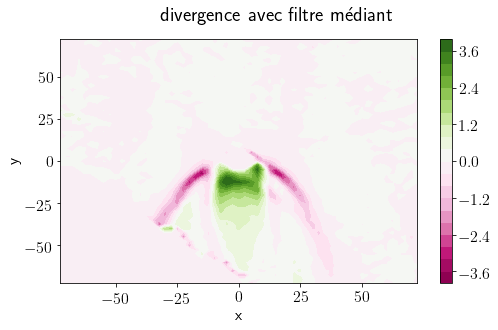

In [9]:
plan=0
plot_divergence(div2D_mediant[plan],dx[plan],dy[plan],'divergence avec filtre médiant','x','y')

### Test size

In [10]:
size=np.arange(1,5,1)

In [11]:
def plot_mediant_size(div,dx,dy,parametre,nom_parametre,title,xlabel,ylabel):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, (l0,l1) = plt.subplots(nrows=2, ncols=2, num=title, figsize=(16,13))
    im0 = l0[0].contourf(dx,dy,div[0],levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0[0])
    l0[0].set_xlabel(xlabel)
    l0[0].set_ylabel(ylabel)
    l0[0].set_title('{} = {}'.format(nom_parametre,parametre[0]))
    
    im1 = l0[1].contourf(dx,dy,div[1],levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im1,ax=l0[1])
    l0[1].set_xlabel(xlabel)
    l0[1].set_ylabel(ylabel)
    l0[1].set_title('{} = {}'.format(nom_parametre,parametre[1]))
    
    im2 = l1[0].contourf(dx,dy,div[2],levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im2,ax=l1[0])
    l1[0].set_xlabel(xlabel)
    l1[0].set_ylabel(ylabel)
    l1[0].set_title('{} = {}'.format(nom_parametre,parametre[2]))
    
    im3 = l1[1].contourf(dx,dy,div[3],levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im3,ax=l1[1])
    l1[1].set_xlabel(xlabel)
    l1[1].set_ylabel(ylabel)
    l1[1].set_title('{} = {}'.format(nom_parametre,parametre[3]))
   
    fig.tight_layout(pad=3)
    fig.suptitle(title,fontsize=20)
    plt.show()

In [12]:
div_size=np.zeros((4,P,59,59))
for i in range(4):
    div_size[i]=divergence2D_mediant(u,v,x,y,size[i])[0]

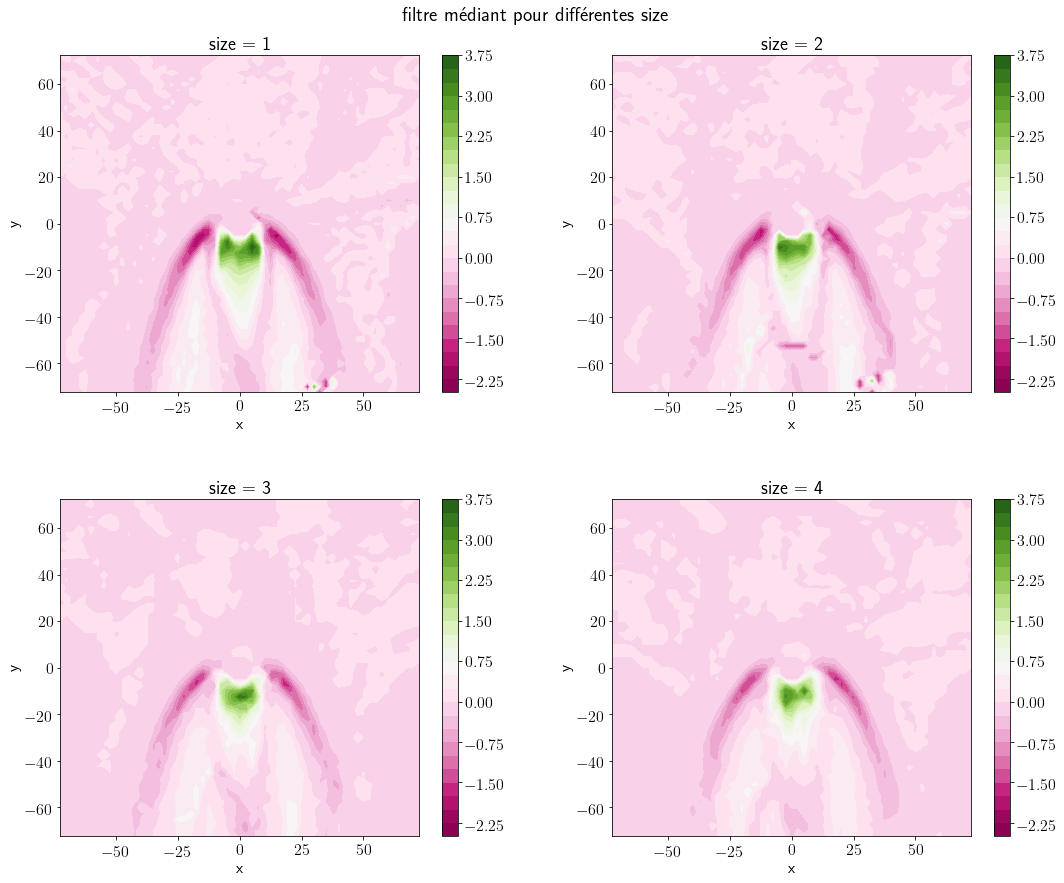

In [13]:
plan=2
plot_mediant_size(div_size[:,plan,:,:],dx[plan],dy[plan],size,'size','filtre médiant pour différentes size','x','y')

### vz

In [14]:
def methode_Galerkine_filtre_mediant(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D,dx,dy=divergence2D_mediant(u,v,x,y,1)
    #Matrice M
    M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))
    pinv=nppinv(M)
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    #calcul de dvz
    dvz=-np.matmul(M,a)
    dvz=np.reshape(dvz,(P,59,59))
    return(vz,dvz)

In [15]:
m=5
vz_mediant,dvz_mediant=methode_Galerkine_filtre_mediant(u,v,x,y,z,P,m,prof)
print(np.shape(vz_mediant),np.shape(dvz_mediant))

(49, 59, 59) (49, 59, 59)


In [16]:
Y=np.arange(-73.75,73.75,2.5)
Z=Z(prof)

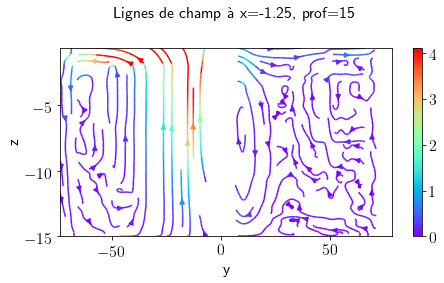

In [17]:
x_plan=29
plot_lignes_champ(np.transpose(conv(v[:,:-1,:-1],x_plan,'x')),np.transpose(conv(vz_mediant,x_plan,'x')),Y,Z,"Lignes de champ à x={}, prof={}".format(Y[x_plan],prof), "y", "z",x_plan)

## Divergence 3D

In [18]:
div3D_mediant=fpd.somme(div2D_mediant,dvz_mediant)
r_mediant=np.where(div2D_mediant==0,0,np.abs(div3D_mediant/div2D_mediant))

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
#print(r_mediant)

# Filtrage gaussien 3D
## Constitution des tableaux

In [20]:
def divergence_gauss3D(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien imbriqué"
    #Filtrage
    u_filtre=gaussian_filter(u,sigma)
    v_filtre=gaussian_filter(v,sigma)
    #dérivation
    du_filtre,dv_filtre=deriv3D(u_filtre,x,2),deriv3D(v_filtre,y,1)
    dx,dy=abcisse3D(x,2),abcisse3D(y,1)
    #shape
    du_filtre,dv_filtre=good_shape3D(du_filtre),good_shape3D(dv_filtre)
    dx,dy=good_shape3D(dx),good_shape3D(dy)
    #somme
    div = fpd.somme(du_filtre,dv_filtre)
    #masque
    div_masque=fpd.masque(div,x,y,dx,dy)
    return(div_masque,dx,dy)

In [21]:
div_gauss3D,dx,dy=divergence_gauss3D(u,v,x,y,1)
print(np.shape(div_gauss3D))

(49, 59, 59)


## Plot
### Premier plot

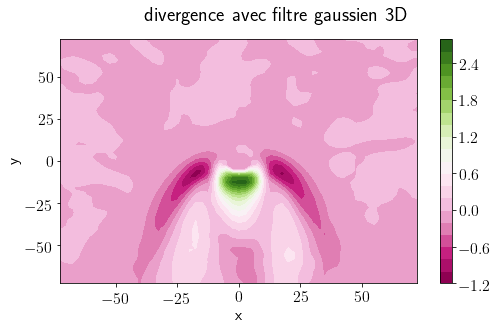

In [22]:
plan=2
plot_divergence(div_gauss3D[plan],dx[plan],dy[plan],'divergence avec filtre gaussien 3D','x','y')

### Pour différents sigmas

In [23]:
sigmas=np.arange(0.5,2.1,0.5)
div_sigmas=np.zeros((4,P,59,59))
for i in range(4):
    div_sigmas[i]=divergence_gauss3D(u,v,x,y,sigmas[i])[0]

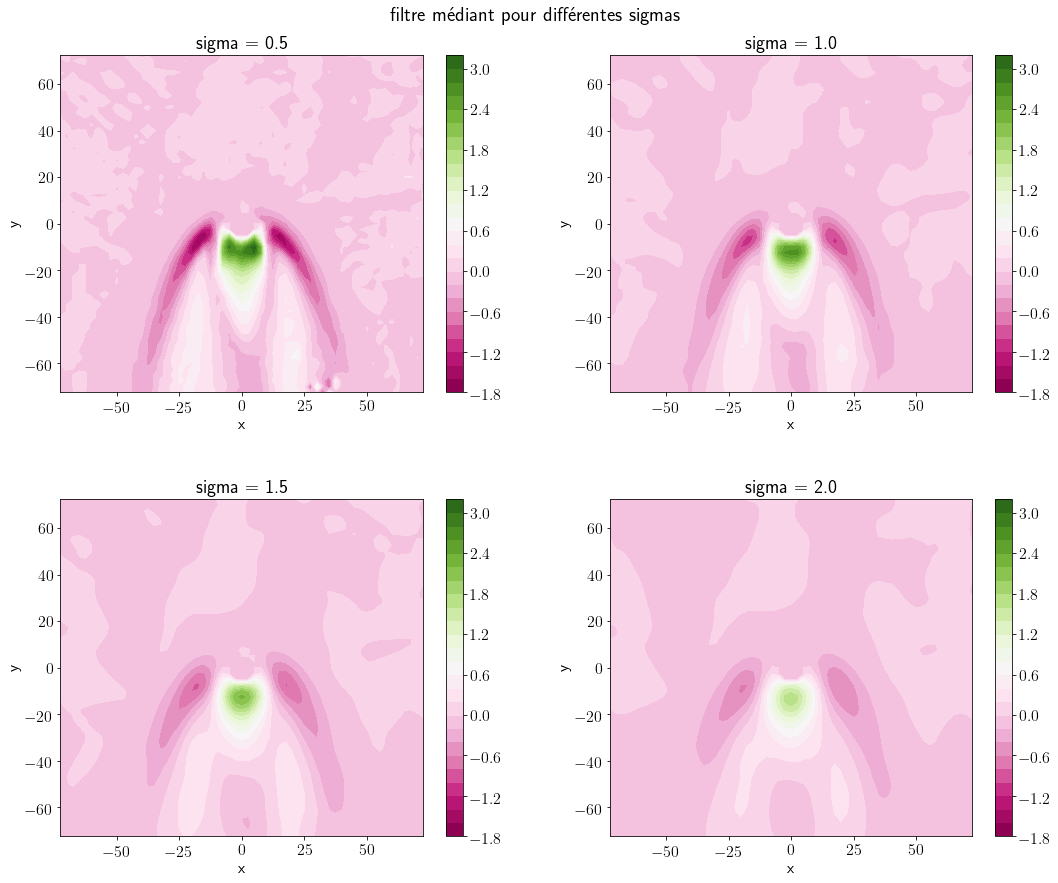

In [24]:
plan=2
plot_mediant_size(div_sigmas[:,plan,:,:],dx[plan],dy[plan],sigmas,'sigma','filtre médiant pour différentes sigmas','x','y')

## vz

In [25]:
def methode_Galerkine_gauss3D(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D,dx,dy=divergence_gauss3D(u,v,x,y,1)
    #Matrice M
    M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))
    pinv=nppinv(M)
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    #calcul de dvz
    dvz=-np.matmul(M,a)
    dvz=np.reshape(dvz,(P,59,59))
    return(vz,dvz)

In [26]:
vz_gauss3D,dvz_gauss3D=methode_Galerkine_gauss3D(u,v,x,y,z,P,m,prof)

<IPython.core.display.Javascript object>


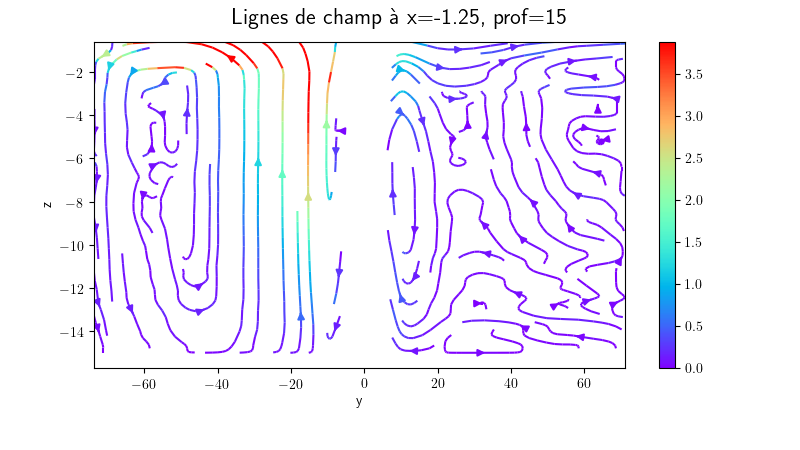

In [28]:
%matplotlib notebook
x_plan=29
plot_lignes_champ(np.transpose(conv(v[:,:-1,:-1],x_plan,'x')),np.transpose(conv(vz_gauss3D,x_plan,'x')),Y,Z,"Lignes de champ à x={}, prof={}".format(Y[x_plan],prof), "y", "z",x_plan)

## Divergence 3D

In [ ]:
div3D_gauss=fpd.somme(div_gauss3D,dvz_gauss3D)
r_gauss3D=np.where(div_gauss3D==0,0,np.abs(div3D_gauss/div_gauss3D))